# Table of Contents

[1. Setup](#1)

[2. Exploratory Data Analysis / Data Preparation](#2)

[3. RFM Analysis](#3)

[4. Clustering based on RFM Analysis](#4)

[5. Feature Engineering and Modeling](#5)

[6. Model Performance](#6)

[7. Results Summary](#7)

## 1. Setup
<a id="1"></a>

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import os

import seaborn as sns
sns.set(style="whitegrid")
from matplotlib import pyplot as plt 

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
order = pd.read_csv('data/order.csv')
online = pd.read_csv('data/online.csv')

## 2. Exploratory Data Analysis / Data Preparation
<a id="2"></a>

### a. order

In [3]:
order.head(3)

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66


In [4]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263278 entries, 0 to 263277
Data columns (total 6 columns):
custno       263278 non-null int64
ordno        263278 non-null int64
orderdate    263278 non-null object
prodcat2     261455 non-null float64
prodcat1     263278 non-null int64
revenue      263278 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 12.1+ MB


In [5]:
print('Exploring order data')
print('No. of unique prodcat1   :: ', order.prodcat1.nunique())
print('Any duplicated orders    :: ', order.duplicated().any())
print('Any duplicated custno    :: ', order.custno.duplicated().any())
print('Any duplicated ordno     :: ', order.ordno.duplicated().any())

Exploring order data
No. of unique prodcat1   ::  6
Any duplicated orders    ::  False
Any duplicated custno    ::  True
Any duplicated ordno     ::  True


In [6]:
order[order.custno==order.ordno].tail(3) # Some early orders have same custno and ordno

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
254171,8,8,2016-06-23 20:28:19,147.0,7,99.12
260540,25,25,2016-01-21 16:10:18,195.0,2,87.54
260567,45,45,2018-09-26 11:54:08,195.0,2,5.36


In [7]:
print('No of records with custno==ordno     :: ', len(order[order.custno==order.ordno]))

No of records with custno==ordno     ::  134


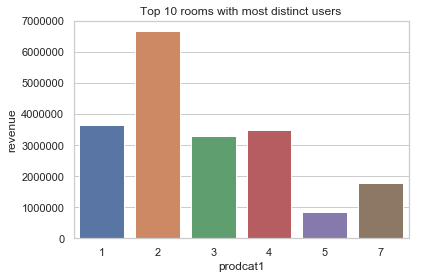

In [8]:
res = order.groupby(order.prodcat1).revenue.sum().reset_index()
sns.barplot(x="prodcat1", y="revenue", data=res);
plt.title('Top 10 rooms with most distinct users');

### b. online

In [9]:
online.head(3)

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1


In [10]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954774 entries, 0 to 954773
Data columns (total 7 columns):
session     954774 non-null int64
visitor     954774 non-null int64
dt          954774 non-null object
custno      954774 non-null int64
category    954774 non-null int64
event1      164928 non-null float64
event2      954774 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 51.0+ MB


In [11]:
print('Exploring online data')
print('Any duplicated rows        :: ', online.duplicated().any())
print('Any duplicated custno      :: ', online.custno.duplicated().any())
print('Any duplicated session     :: ', online.session.duplicated().any())
print('Any duplicated visitor     :: ', online.visitor.duplicated().any())
print('Unique event1              :: ', online.event1.unique())
print('Unique event2              :: ', online.event2.unique())
print('Unique category            :: ', online.category.unique())

Exploring online data
Any duplicated rows        ::  False
Any duplicated custno      ::  True
Any duplicated session     ::  True
Any duplicated visitor     ::  True
Unique event1              ::  [nan  1.  2.  4.  5.  6.  7.  8.  9. 10. 11.]
Unique event2              ::  [ 1  2  3  4  5  6  7  8  9 10]
Unique category            ::  [1 2 3]


In [12]:
order = order[order.prodcat1.isin([1.0,2.0,3.0])]  # Need both datasets to be consistent in categories (this is the target variable!)

### c. Merge datasets

In [13]:
data = pd.merge(online, order, on='custno', how='outer').sort_values(by=['dt', 'orderdate'])
data.reset_index(inplace=True, drop=True)
data['orderdate'] = pd.to_datetime(data['orderdate'])
data['dt'] = pd.to_datetime(data['dt'])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4825233 entries, 0 to 4825232
Data columns (total 12 columns):
session      float64
visitor      float64
dt           datetime64[ns]
custno       int64
category     float64
event1       float64
event2       float64
ordno        float64
orderdate    datetime64[ns]
prodcat2     float64
prodcat1     float64
revenue      float64
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 441.8 MB


In [15]:
data.head(3)

,session,visitor,dt,custno,category,event1,event2,ordno,orderdate,prodcat2,prodcat1,revenue
0,1599047.0,258187.0,2016-01-01 00:00:08,36112,3.0,NaN,7.0,NaN,NaT,NaN,NaN,NaN
1,284812.0,419022.0,2016-01-01 00:01:47,68246,1.0,NaN,7.0,144652.0,2017-06-21 13:16:46,9.0,3.0,16.22
2,1004067.0,125012.0,2016-01-01 00:20:48,66408,3.0,NaN,7.0,NaN,NaT,NaN,NaN,NaN


In [16]:
print('No. of visitors with no purchases           :: ', len(data[data.ordno.isnull()]))
print('No. of purchases with no browsing history   :: ', len(data[data.session.isnull()]))
print('Min and max timestamps in order             :: ', data.orderdate.min(), data.orderdate.max())
print('Min and max timestamps in online            :: ', data.dt.min(), data.dt.max() )

No. of visitors with no purchases           ::  277443
No. of purchases with no browsing history   ::  23176
Min and max timestamps in order             ::  2016-01-01 06:34:56 2019-01-02 23:54:58
Min and max timestamps in online            ::  2016-01-01 00:00:08 2017-12-31 23:58:05


In [17]:
data = data[data.orderdate<='2017-12-31']

In [18]:
print('Unique customers                     :: ', data.custno.nunique())
print('Unique customers for unique orders   :: ', data[data.ordno.notnull()].custno.nunique())
print('Unique orders                        :: ', data.ordno.nunique())

Unique customers                     ::  37647
Unique customers for unique orders   ::  37647
Unique orders                        ::  74591


## 3. RFM Analysis
<a id="3"></a>

In [19]:
def buildRFMData(data, currentDate=datetime(2018,1,1)):
    rfm= data.groupby('custno').agg({'orderdate': lambda date: (currentDate - date.max()).days,
                                 'ordno': lambda n: len(n),
                                 'revenue': lambda revenue: revenue.sum(),
                                 'prodcat1': lambda x: x.iloc[-1:],
                                })
    rfm.columns=['recency', 'frequency', 'monetary', 'lastCatPurchased']
    rfm.reset_index(inplace=True)
    rfm.recency = rfm.recency.astype(int)
    rfm.frequency = rfm.frequency.astype(int)
    rfm.monetary = rfm.monetary.astype(int)
    rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
    rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
    rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
    rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
    return rfm

rfm = buildRFMData(data)

In [20]:
rfm.head(3)

,custno,recency,frequency,monetary,lastCatPurchased,r_quartile,f_quartile,m_quartile,RFM_Score
0,1,202,1,8,1.0,2,4,4,244
1,2,243,5,313,1.0,2,3,3,233
2,3,276,6,565,1.0,2,3,3,233


In [21]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37647 entries, 0 to 37646
Data columns (total 9 columns):
custno              37647 non-null int64
recency             37647 non-null int64
frequency           37647 non-null int64
monetary            37647 non-null int64
lastCatPurchased    37647 non-null float64
r_quartile          37647 non-null category
f_quartile          37647 non-null category
m_quartile          37647 non-null category
RFM_Score           37647 non-null object
dtypes: category(3), float64(1), int64(4), object(1)
memory usage: 1.8+ MB


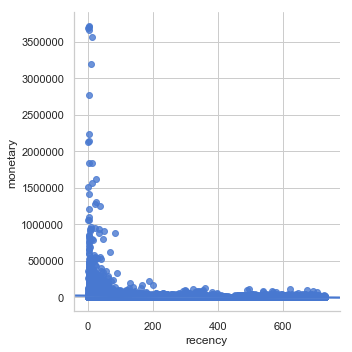

In [22]:
sns.set_palette('muted')
sns.lmplot(x="recency", y="monetary", data=rfm)

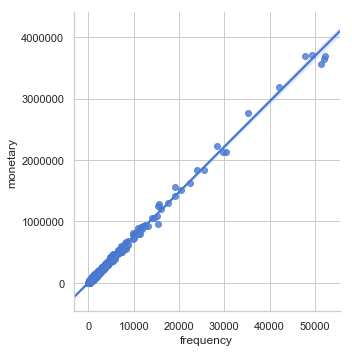

In [23]:
sns.lmplot(x="frequency", y="monetary", data=rfm)

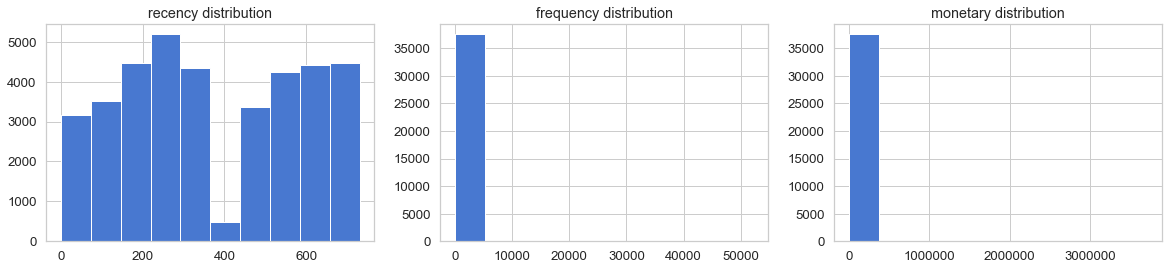

In [24]:
sns.set(style="whitegrid", font_scale=1.2);
sns.set_palette('muted')
plt.subplots(figsize = (20,4));
plt.subplot(1,3,1);
plt.title('recency distribution')
rfm.recency.hist();
plt.subplot(1, 3, 2);
plt.title('frequency distribution')
rfm.frequency.hist();
plt.subplot(1, 3, 3);
plt.title('monetary distribution')
rfm.monetary.hist();

In [25]:
len(rfm[rfm.monetary<1])

51

In [26]:
rfm['monetary'] = rfm['monetary'].apply(lambda x: x if x>0 else 1)

In [27]:
rfm.head()

,custno,recency,frequency,monetary,lastCatPurchased,r_quartile,f_quartile,m_quartile,RFM_Score
0,1,202,1,8,1.0,2,4,4,244
1,2,243,5,313,1.0,2,3,3,233
2,3,276,6,565,1.0,2,3,3,233
3,4,115,7,347,1.0,1,3,3,133
4,5,715,1,90,1.0,4,4,4,444


In [28]:
rfm['r_log'] = np.log10(rfm['recency'])
rfm['f_log'] = np.log10(rfm['frequency'])
rfm['m_log'] = np.log10(rfm['monetary'])

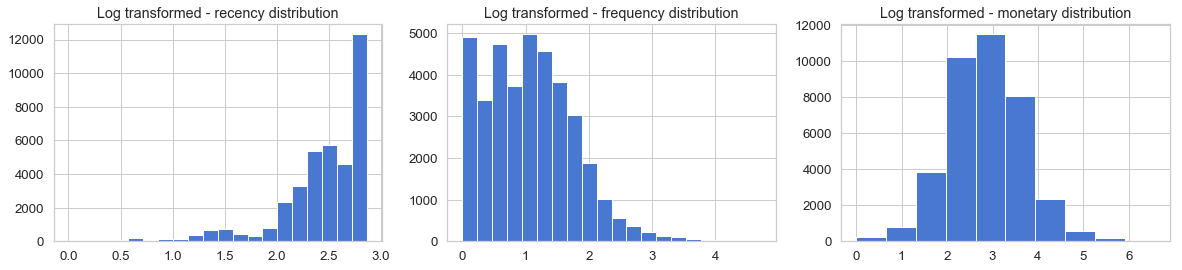

In [29]:
sns.set(style="whitegrid", font_scale=1.2);
sns.set_palette('muted')
plt.subplots(figsize = (20,4));
plt.subplot(1,3,1);
plt.title('Log transformed - recency distribution')
rfm.r_log.hist(bins=20)
plt.subplot(1, 3, 2);
plt.title('Log transformed - frequency distribution')
rfm.f_log.hist(bins=20)
plt.subplot(1, 3, 3);
plt.title('Log transformed - monetary distribution')
rfm.m_log.hist()

In [30]:
scaler = MinMaxScaler()
scaler.fit(rfm)
scaler.transform(rfm)

array([[0.00000000e+00, 2.75720165e-01, 0.00000000e+00, ...,
        8.05131479e-01, 0.00000000e+00, 1.37460901e-01],
       [1.40007000e-05, 3.31961591e-01, 7.65946039e-05, ...,
        8.33160070e-01, 1.48153719e-01, 3.79851152e-01],
       [2.80014001e-05, 3.77229081e-01, 9.57432549e-05, ...,
        8.52474276e-01, 1.64936980e-01, 4.18894090e-01],
       ...,
       [9.99915996e-01, 6.51577503e-01, 5.74459529e-05, ...,
        9.35139725e-01, 1.27612667e-01, 4.07424199e-01],
       [9.99971999e-01, 3.04526749e-01, 1.34040557e-04, ...,
        8.20132754e-01, 1.91419001e-01, 3.95566432e-01],
       [1.00000000e+00, 8.60082305e-01, 2.68081114e-04, ...,
        9.77172251e-01, 2.49284365e-01, 4.11733975e-01]])

## 4. Clustering based on RFM Analysis

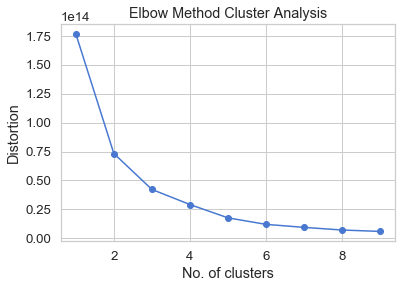

In [31]:
distortions = []
for i in range(1, 10):
    km = KMeans(n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0)
    km.fit(rfm)
    distortions.append(km.inertia_)
    
plt.plot(range(1,10), distortions, marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Method Cluster Analysis")
plt.show()

In [32]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0)
kmeans = km.fit(scaler.transform(rfm))
y_km = km.fit_predict(scaler.transform(rfm))
rfm['cluster'] = kmeans.labels_

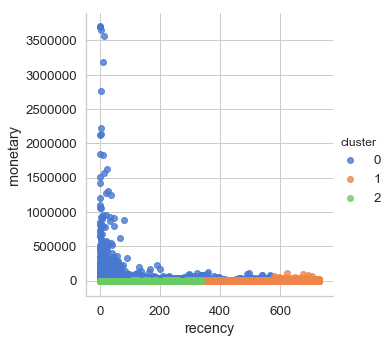

In [33]:
sns.lmplot(x="recency", y="monetary", hue="cluster", data=rfm, fit_reg=False);

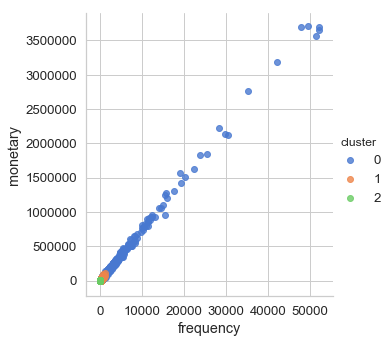

In [34]:
sns.lmplot(x="frequency", y="monetary", hue="cluster", data=rfm, fit_reg=False);

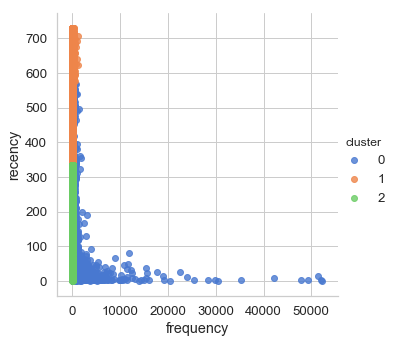

In [35]:
sns.lmplot(x="frequency", y="recency", hue="cluster", data=rfm, fit_reg=False);

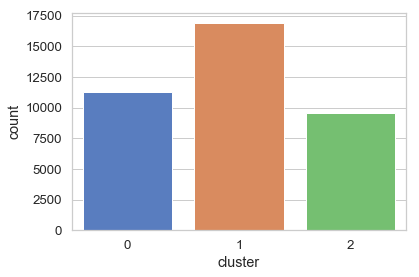

In [36]:
sns.countplot(x='cluster', data=rfm);

# Feature Engineering and Modeling
<a id="5"></a>

In [37]:
def getData(data, rfm):
    sessions = data.groupby('custno').agg({'ordno': lambda n: 1 if len(n)>1 else 0,
                                       'visitor': lambda n: 1 if len(n)>1 else 0,
                                       'session': lambda n: n.count(),
                                       'event1': lambda n: n.iloc[-1:],
                                       'event2': lambda n: n.iloc[-1:]
                                      })
    sessions.reset_index(inplace=True)
    sessions.columns = ['custno', 'isRepeatCustomer', 'isRepeatVisitor', 'sessionCnt', 'lastEvent1', 'lastEvent2']
    train = pd.merge(rfm, sessions, on='custno', how='inner')
    features = ['recency', 'frequency', 'monetary', 'cluster', 'isRepeatCustomer', 'isRepeatVisitor', 'sessionCnt', 'lastEvent1', 'lastEvent2']
    cols = features + ['custno', 'lastCatPurchased']
    train = train[cols]
    train.fillna(0, inplace=True)
    return train, features

train, features = getData(data, rfm)

In [38]:
X, y = train[features], train['lastCatPurchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [39]:
params = {'n_estimators': np.arange(10,100,10),
          'max_depth':np.arange(5,20,5), 
          'min_samples_split':np.arange(200,1001,200)}

# params = {'n_estimators': np.arange(10,20,10)}

model = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=7), 
param_grid = params, n_jobs=4,iid=False, cv=5)
model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90]), 'max_depth': array([ 5, 10, 15]), 'min_samples_split': array([ 200,  400,  600,  800, 1000])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [40]:
model.grid_scores_, model.best_params_, model.best_score_

([mean: 0.48706, std: 0.00348, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 10},
  mean: 0.48797, std: 0.00278, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 20},
  mean: 0.49058, std: 0.00241, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 30},
  mean: 0.49249, std: 0.00302, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 40},
  mean: 0.49443, std: 0.00247, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 50},
  mean: 0.49732, std: 0.00284, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 60},
  mean: 0.49883, std: 0.00303, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 70},
  mean: 0.50054, std: 0.00353, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 80},
  mean: 0.50204, std: 0.00406, params: {'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 90},
  mean: 0.48642, std: 0.00247, params: {'max_depth': 5, 'min_samples_spli

In [41]:
model = model.best_estimator_
preds = model.predict(X_test)

## Model performance
<a id="6"></a>

In [42]:
print('Train score   :: ', round(model.score(X_train, y_train), 4)*100, '%')
print('Test score    :: ', round(model.score(X_test, y_test), 4)*100, '%')

Train score   ::  55.32 %
Test score    ::  52.129999999999995 %


In [43]:
predData = {'actuals': y_test, 'predicted': preds}
f = pd.DataFrame(predData)
f.reset_index(inplace=True, drop=True)
f.head(3)

,actuals,predicted
0,2.0,2.0
1,3.0,3.0
2,2.0,1.0


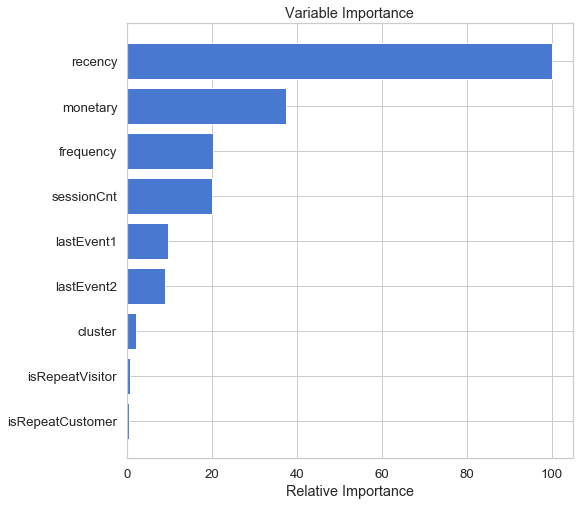

In [44]:
def variableImportance(model, features, thershold=0):
  feature_importance = model.feature_importances_
  feature_importance = 100.0 * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)
  values = feature_importance[sorted_idx]
  names = [features[i] for i in sorted_idx]
  values_tops = []
  names_tops = []
  for i, value in enumerate(values):
    if value>thershold:
      values_tops.append(value)
      names_tops.append(names[i])
  return names_tops, values_tops

names,values = variableImportance(model , features)
pos = np.arange(len(values)) + 0.5
plt.figure(figsize=(8,8))
plt.barh(pos, values, align='center')
plt.yticks(pos, names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Results Summary
<a id="7"></a>

### Assumptions/ Challenges

1. Dataset was significantly compressed due to unavailability of online data 2018 onwards as well as missing product category data for 3 out of the 6 categories in online dataset
2. event1 and event2 have been used as is without any transformation
3. In the interest of time, RFM analysis was not further tuned to get optimal normalized distributions
4. Since this analysis is based on 2016-17 dataset, no inference can be drawn for recent customer clusters and/or purchase patterns. This can at best be used as retrospective analyses.

### Observations

1. **RFM Analysis**

    1. Majority purchases of high monetary value were made recently
    2. Low monetary value items were purhcased frequently
    3. Recency distribution indicates seasonality. This can be confirmed with more data.
    4. There are several outliers in frequency especially with high monetary items. Given more time, would like to assess these outliers separately to understand these customers and purchase patterns.

2. **Clustering**
    
    1. Elbow plot analysis clearly indicated 3 optimal clusters for this dataset. Below are the customer segments:
    
        1. Customers who purchased low monetary products recently (last 1 year)
        2. Customers who purchased low monetary products in the past (>1 year)
        3. Customers who purchased high monetary products any time

3. **Modeling**

    1. Given the multi-class classfication problem, used an ensemble technique - Gradient Boosting Classfier model - to predict the product category purchased by the customer.
    2. Achieved a score of 52.2% on test dataset.
        
### Next Steps

1. Explore more features from the data like browsing session averages and patterns impacting purchases of specific product categories
2. Explore individual customer segments and outliers in purchasing patterns
3. Further hyperparameter tuning of the model and exploring other classification models/ recommendation systems
4. Evaluate precision/ recall/ F1 score for the model classifications instead of relying on average score
5. Could also use probability classifiers to predict multiple products instead of single purchase depending upon where and how this model will be used.